In [10]:
import pandas as pd
import sklearn.datasets as data

In [11]:
# Load dataset
df_titanic = pd.read_csv(r'C:\Users\marku\Desktop\ML\MLGit\datasets\titanic.csv')

In [12]:
df_titanic = df_titanic.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

In [13]:
# Sets null values equal to the median of that column
def handle_null_median(df):
    # Need to set inplace=True, so it doesn't create a copy of the dataframe. Tried without and this led to null-values not being removed
    df['Fare'].fillna(df['Fare'].median(), inplace=True)
    df['Age'].fillna(df['Age'].median(), inplace=True)

    df['Embarked'].fillna('S', inplace=True)

    return  df

df_titanic = handle_null_median(df_titanic)

In [14]:
df_titanic['Sex'] = df_titanic['Sex'].replace(['female', 'male'], [0,1])

In [15]:
df_titanic['FamilyMembersCount'] = df_titanic['Parch'] + df_titanic['SibSp'] + 1

In [16]:
df_XGB = df_titanic.copy()
df_RF = df_titanic.copy()
df_GNB = df_titanic.copy()

In [17]:
def bins(df): # This is kind of feature engineering as well
    df['AgeGroup'] = 0
    df.loc[df['Age'] < 16.336, 'AgeGroup' ] = 0
    df.loc[(df['Age'] >= 16.336) & (df['Age'] < 32.252), 'AgeGroup'] = 1
    df.loc[(df['Age'] >= 32.252) & (df['Age'] < 48.168), 'AgeGroup'] = 2
    df.loc[(df['Age'] >= 48.168) & (df['Age'] < 64.084), 'AgeGroup'] = 3
    df.loc[df['Age'] >= 64.084, 'AgeGroup'] = 4

    # Could also create bins for fare, but not sure Fare is needed.
    return df

df_XGB = bins(df_titanic)
df_XGB

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilyMembersCount,AgeGroup
0,0,3,1,22.0,1,0,7.2500,S,2,1
1,1,1,0,38.0,1,0,71.2833,C,2,2
2,1,3,0,26.0,0,0,7.9250,S,1,1
3,1,1,0,35.0,1,0,53.1000,S,2,2
4,0,3,1,35.0,0,0,8.0500,S,1,2
...,...,...,...,...,...,...,...,...,...,...
886,0,2,1,27.0,0,0,13.0000,S,1,1
887,1,1,0,19.0,0,0,30.0000,S,1,1
888,0,3,0,28.0,1,2,23.4500,S,4,1
889,1,1,1,26.0,0,0,30.0000,C,1,1


In [18]:
df_titanic['Pclass'] =  df_titanic['Pclass'].astype('category')
df_titanic['Embarked'] =  df_titanic['Embarked'].astype('category')
df_titanic['AgeGroup'] =  df_titanic['AgeGroup'].astype('category')

In [19]:
df_XGB = pd.get_dummies(df_titanic)
df_RF = pd.get_dummies(df_titanic)
df_GNB = pd.get_dummies(df_titanic)

In [20]:
from sklearn.model_selection import train_test_split

# XGBoost

In [21]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

train_X, test_X, train_y, test_y = train_test_split(df_XGB.drop('Survived', axis=1), df_XGB['Survived'], random_state=0)

model = XGBClassifier()
model.fit(train_X, train_y)

pred_y = model.predict(test_X)
preds = [round(value) for value in pred_y]

# evaluate predictions
accuracy = accuracy_score(test_y, preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[11:10:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 82.96%


C:\Users\marku\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\marku\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\marku\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [ ]:
from sklearn.model_selection import GridSearchCV
XGBParam = {"colsample_bytree":[0.5, 0.75, 1],
              "max_depth":[2, 6, 12],
              "min_child_weight":[1,5,15],
              "learning_rate":[0.3, 0.1, 0.03],
              "n_estimators":[50, 100, 200, 300]}

XGB_grid = GridSearchCV(XGBClassifier(verbosity=0), XGBParam)
XGB_grid.fit(train_X, train_y)

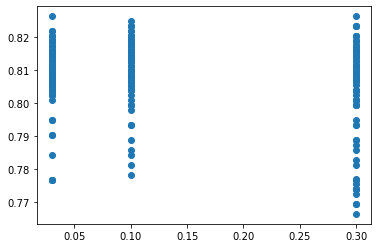

In [23]:
gb_results = pd.DataFrame(XGB_grid.cv_results_)

import matplotlib.pyplot as plt

plt.scatter(gb_results['param_learning_rate'], gb_results['mean_test_score'])

In [24]:
print(XGB_grid.best_score_)

0.8263606778139378


In [25]:
print(XGB_grid.best_params_)

{'colsample_bytree': 0.75, 'learning_rate': 0.3, 'max_depth': 12, 'min_child_weight': 5, 'n_estimators': 100}


# Random Forrest Classifier

In [26]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

train_X, test_X, train_y, test_y = train_test_split(df_RF.drop('Survived', axis=1), df_RF['Survived'], random_state=0)

# Train and test random forest classifier with default parameters
rf_scores = cross_val_score(RandomForestClassifier(), train_X, train_y)
(rf_scores.mean(), rf_scores.std())

(0.7993940074065762, 0.020378342440628965)

In [28]:
RFParam = {"max_features":['auto'],
            "max_depth":[2, 6, 12, 24, 48, 96],
            "n_estimators":[50, 100, 200, 300]}

RF_Grid = GridSearchCV(RandomForestClassifier(), RFParam)
RF_Grid.fit(train_X, train_y)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 6, 12, 24, 48, 96],
                         'max_features': ['auto'],
                         'n_estimators': [50, 100, 200, 300]})

In [31]:
print(RF_Grid.best_score_)

0.8143642688811582


In [32]:
print(RF_Grid.best_params_)

{'max_depth': 6, 'max_features': 'auto', 'n_estimators': 300}


# GaussianNB

In [ ]:
from sklearn.naive_bayes import GaussianNB

train_X, test_X, train_y, test_y = train_test_split(df_RF.drop('Survived', axis=1), df_RF['Survived'], random_state=0)

# Train and test random forest classifier with default parameters
GNB_scores = cross_val_score(GaussianNB(), train_X, train_y)
(GNB_scores.mean(), GNB_scores.std())